In [1]:
from statsforecast import StatsForecast
from statsforecast.models import (Naive, SeasonalNaive, AutoARIMA, AutoETS, AutoTheta, AutoCES)
from datasetsforecast.losses import mse, mae, mape, smape
import yfinance as yf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore


from typing import List, Callable
from distributed import Client
from fugue import transform
from fugue_dask import DaskExecutionEngine

import warnings
warnings.filterwarnings("ignore")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsforecast/core.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
# Descargar datos
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'IBM', 'BTC-USD']
Y_df = yf.download(tickers, start='2015-01-01', interval='1d')['Adj Close']

# Resetear el índice y transformar el DataFrame
Y_df = Y_df.reset_index().melt(id_vars='Date', var_name='unique_id', value_name='y')
Y_df = Y_df.rename(columns={'Date': 'ds'})
Y_df = Y_df[['unique_id', 'ds', 'y']]
Y_df['y'] = np.log(Y_df['y'].div(Y_df.groupby('unique_id')['y'].shift(1)))
Y_df = Y_df.dropna(subset=['y']).reset_index(drop=True)
Y_df

[*********************100%%**********************]  8 of 8 completed


,unique_id,ds,y
0,AAPL,2015-01-06,0.000094
1,AAPL,2015-01-07,0.013925
2,AAPL,2015-01-08,0.037703
3,AAPL,2015-01-09,0.001072
4,AAPL,2015-01-13,0.008839
...,...,...,...
16645,NVDA,2024-07-09,0.024502
16646,NVDA,2024-07-10,0.026514
16647,NVDA,2024-07-11,-0.057276
16648,NVDA,2024-07-12,0.014339


In [3]:
Y_df['Z-Score'] = Y_df.groupby('unique_id')['y'].transform(lambda x: zscore(x, nan_policy='omit'))
data = Y_df[Y_df['unique_id'] == 'NVDA']
data

,unique_id,ds,y,Z-Score
14770,NVDA,2015-01-06,-0.030788,-1.099578
14771,NVDA,2015-01-07,-0.002609,-0.160056
14772,NVDA,2015-01-08,0.036927,1.158109
14773,NVDA,2015-01-09,0.004020,0.060965
14774,NVDA,2015-01-13,-0.001525,-0.123914
...,...,...,...,...
16645,NVDA,2024-07-09,0.024502,0.743861
16646,NVDA,2024-07-10,0.026514,0.810930
16647,NVDA,2024-07-11,-0.057276,-1.982729
16648,NVDA,2024-07-12,0.014339,0.405016


In [4]:
def detect_and_correct_anomalies(group):
    group = group.sort_values(by='ds', ascending=True).reset_index(drop=True)
    group['Z-Score'] = abs(zscore(group['y']))

    # Detectar y corregir anomalías
    group.loc[group['Z-Score'] > 2.5, 'y'] = np.nan
    group['y'] = group['y'].interpolate(method='linear')

    # Eliminar la columna Z-Score
    group = group.drop(columns=['Z-Score'])

    return group

ts_not_anom= Y_df.groupby('unique_id').apply(detect_and_correct_anomalies).reset_index(drop=True)
ts_not_anom

,unique_id,ds,y
0,AAPL,2015-01-06,0.000094
1,AAPL,2015-01-07,0.013925
2,AAPL,2015-01-08,0.037703
3,AAPL,2015-01-09,0.001072
4,AAPL,2015-01-13,0.008839
...,...,...,...
16645,NVDA,2024-07-09,0.024502
16646,NVDA,2024-07-10,0.026514
16647,NVDA,2024-07-11,-0.057276
16648,NVDA,2024-07-12,0.014339


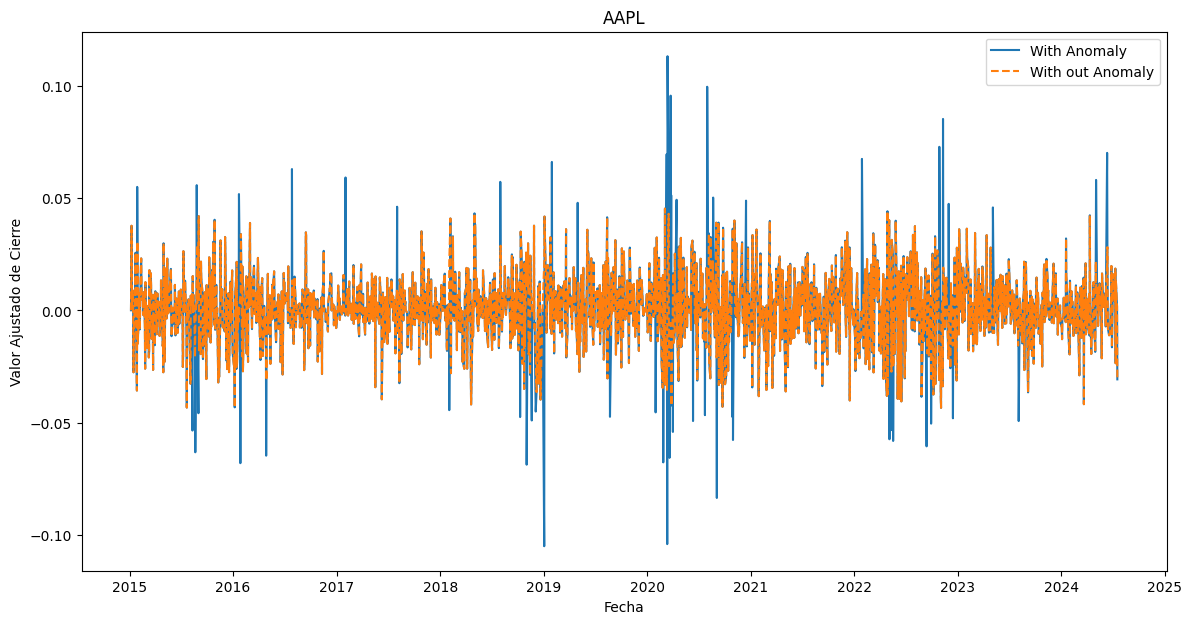

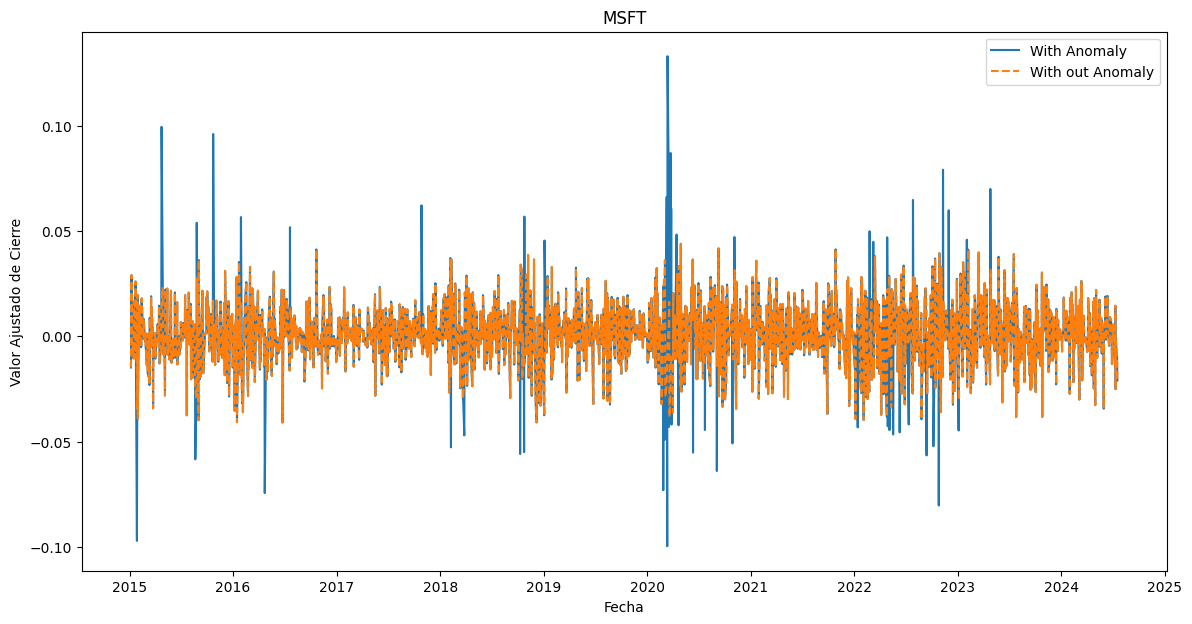

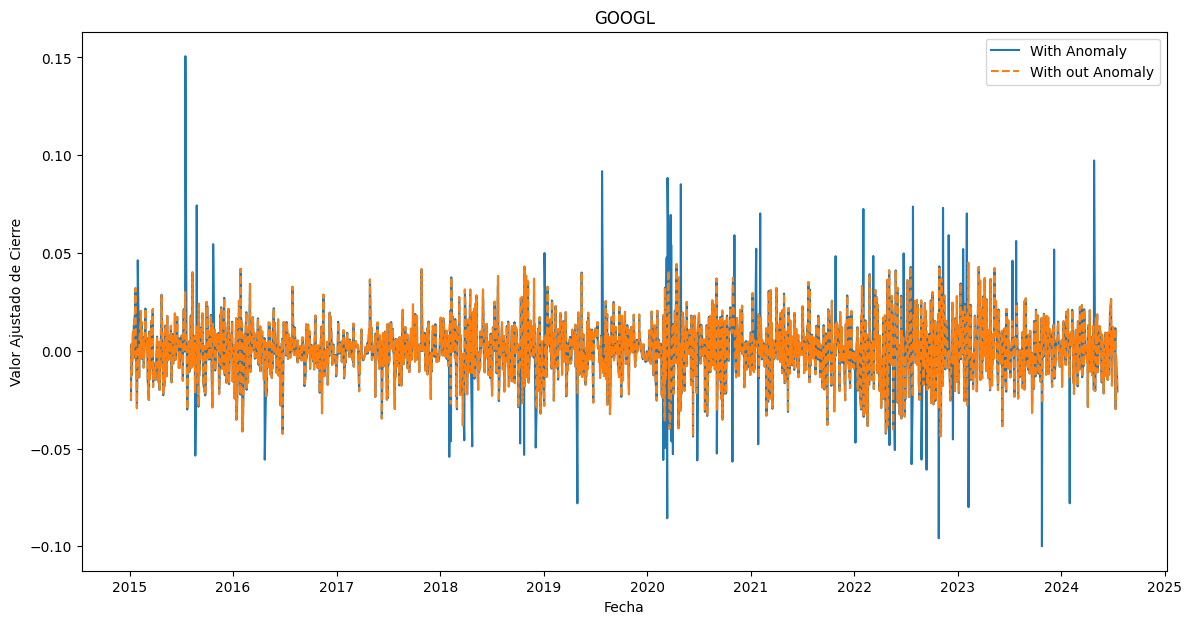

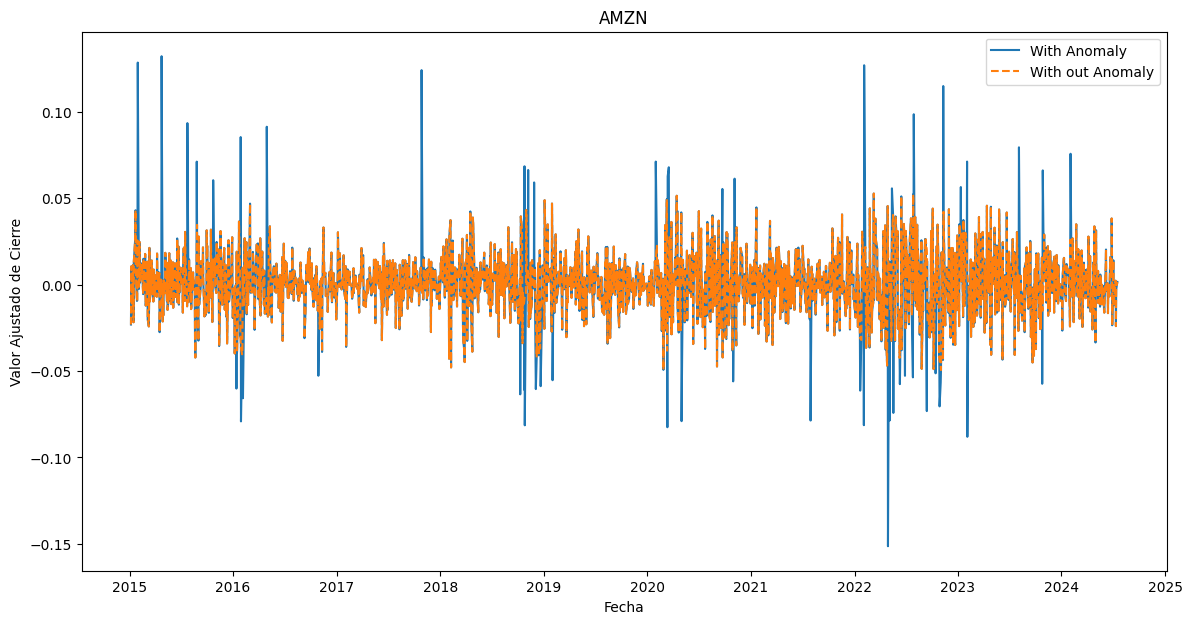

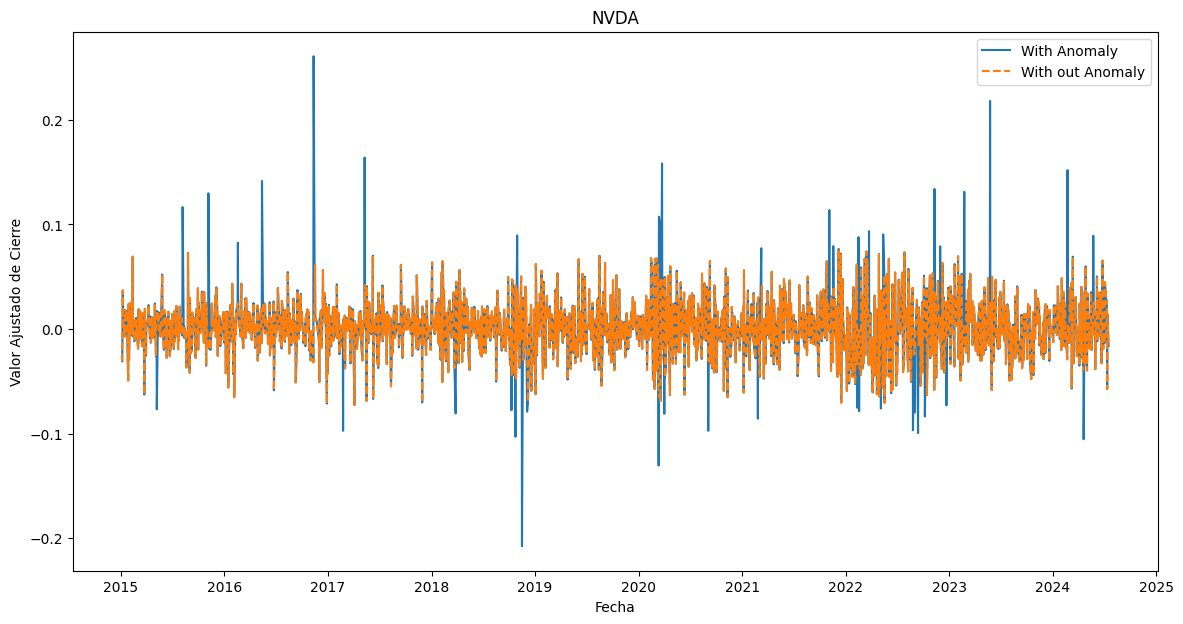

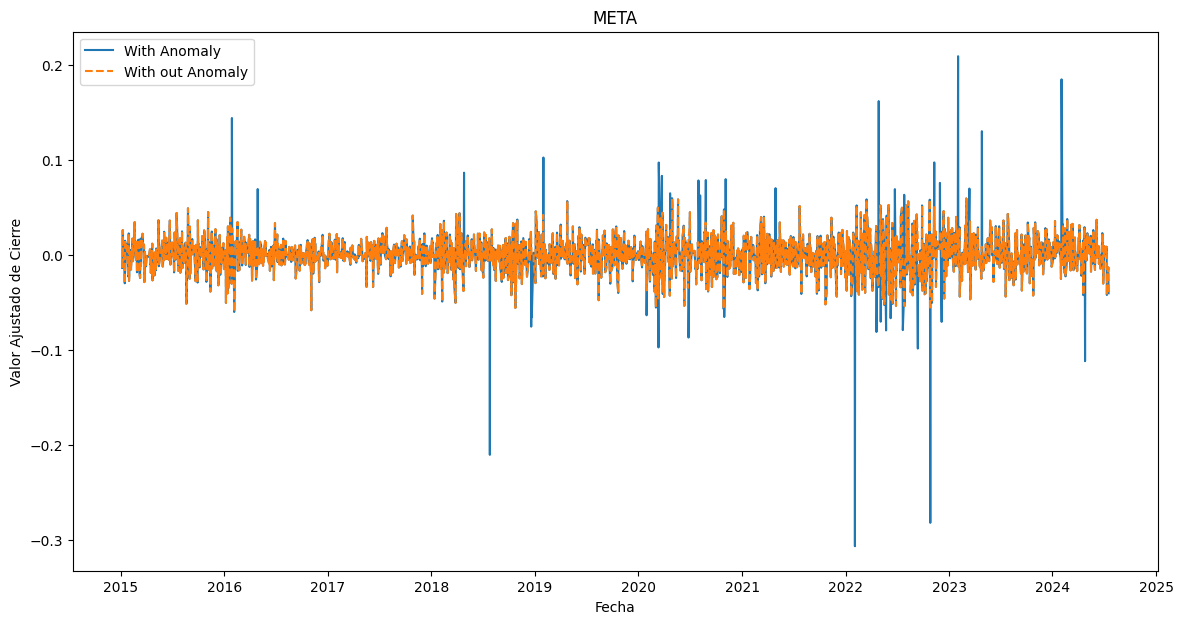

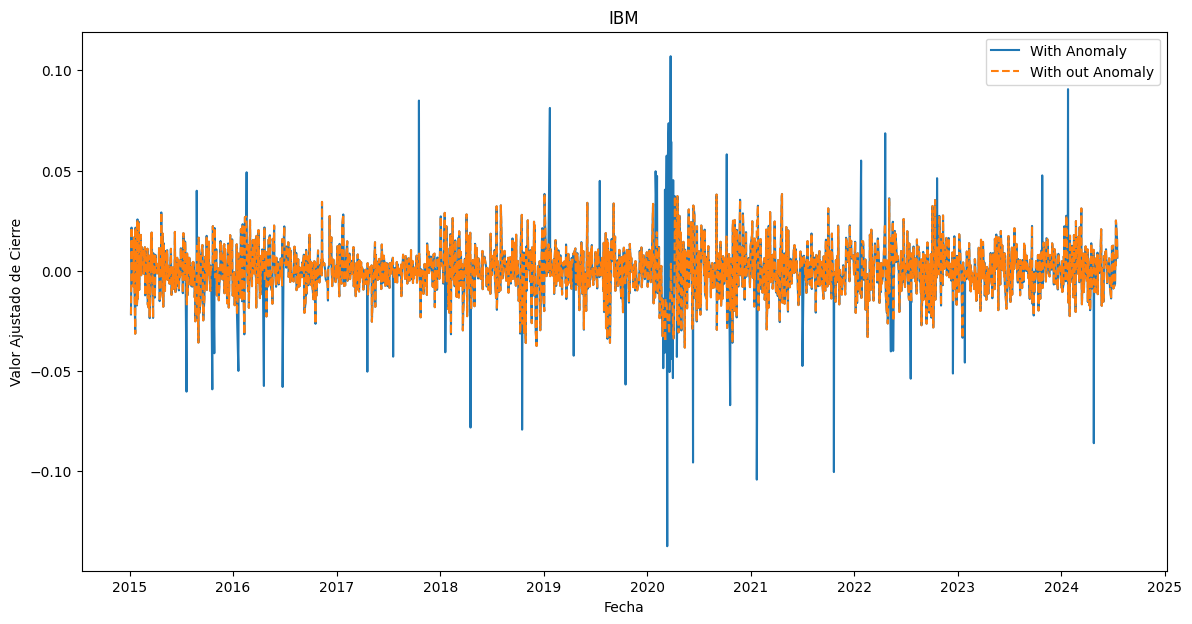

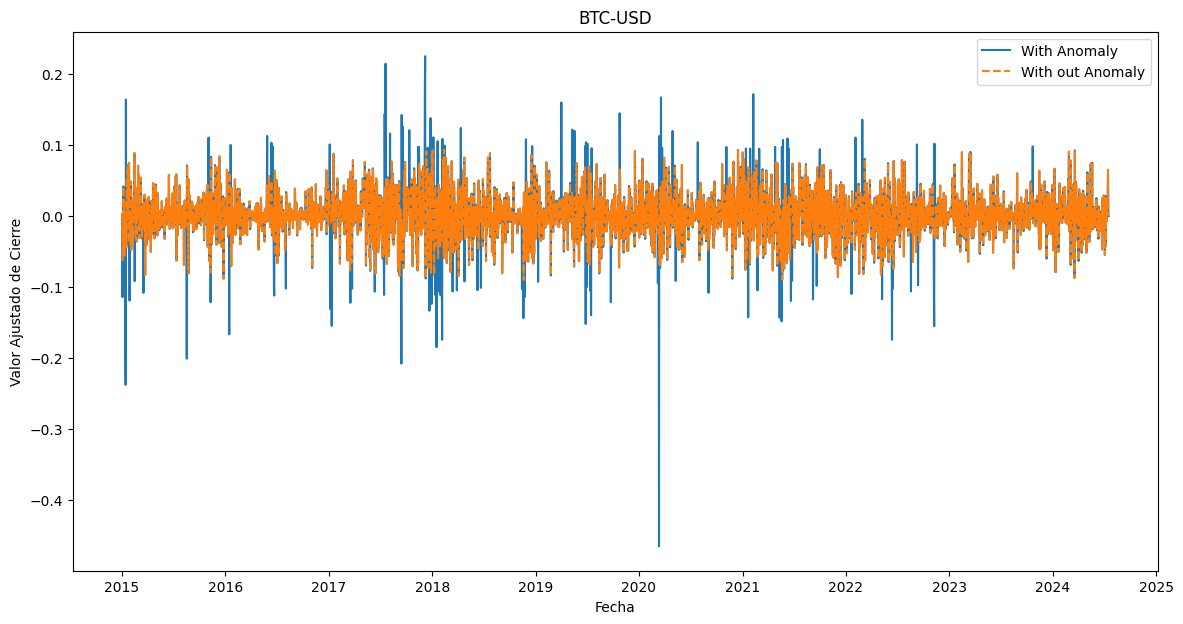

In [5]:
# Agrupar los datos originales y corregidos por 'unique_id' (ticker)
ts_original = Y_df.groupby('unique_id')
ts_corrected = ts_not_anom.groupby('unique_id')

# Iterar sobre cada ticker y graficar
for ticker in tickers:
    plt.figure(figsize=(14, 7))

    # Datos originales
    original_data = ts_original.get_group(ticker)
    corrected_data = ts_corrected.get_group(ticker)

    plt.plot(original_data['ds'], original_data['y'], label='With Anomaly')
    plt.plot(corrected_data['ds'], corrected_data['y'], label='With out Anomaly', linestyle='--')

    plt.title(f'{ticker}')
    plt.xlabel('Fecha')
    plt.ylabel('Valor Ajustado de Cierre')
    plt.legend()
    plt.show()

In [6]:
# Contar NaNs por unique_id
nan_counts = ts_not_anom.groupby('unique_id')['y'].apply(lambda x: x.isna().sum())
print(nan_counts)

unique_id
AAPL       0
AMZN       0
BTC-USD    0
GOOGL      0
IBM        0
META       0
MSFT       0
NVDA       0
Name: y, dtype: int64


In [7]:
season_length = 7 # Define season length as 7 months for daily data
horizon = 28 # Forecast horizon is set to 28 days

# Define a list of models for forecasting
models = [
    Naive(),
    SeasonalNaive(season_length=season_length),
    AutoARIMA(season_length=season_length), # ARIMA model with automatic order selection and seasonal component
    AutoETS(season_length=season_length), # ETS model with automatic error, trend, and seasonal component
    AutoTheta(season_length=season_length), # Theta model with automatic seasonality detection
    AutoCES(season_length=season_length), # CES model with automatic seasonality detection
    
]

# Instantiate StatsForecast class with models, data frequency ('M' for monthly),
# and parallel computation on all CPU cores (n_jobs=-1)
sf = StatsForecast(
    models=models, # models for forecasting
    freq='D',  # frequency of the data
    n_jobs=1  # number of jobs to run in parallel, -1 means using all processors
)

In [8]:
# Generate forecasts for the specified horizon using the sf object
Y_hat_df = sf.forecast(df=ts_not_anom, h=horizon) # forecast data
Y_hat_df.head() 

,ds,Naive,SeasonalNaive,AutoARIMA,AutoETS,AutoTheta,CES
unique_id,,,,,,,
AAPL,2024-07-18,-0.030659,0.005794,-1.754829e-03,0.000883,-0.000148,-0.000220
AAPL,2024-07-19,-0.030659,0.003768,-1.004424e-04,0.000883,-0.000148,-0.000161
AAPL,2024-07-20,-0.030659,0.018629,-5.749098e-06,0.000883,-0.000148,0.000793
AAPL,2024-07-21,-0.030659,-0.023495,-3.290654e-07,0.000883,-0.000148,0.000195
AAPL,2024-07-22,-0.030659,0.012966,-1.883496e-08,0.000883,-0.000148,0.000981


In [9]:
cv_df = sf.cross_validation(df=ts_not_anom, h=horizon, n_windows=4, step_size=horizon, level=[95])
cv_df.head()

,ds,cutoff,y,Naive,Naive-lo-95,Naive-hi-95,SeasonalNaive,SeasonalNaive-lo-95,SeasonalNaive-hi-95,AutoARIMA,...,AutoARIMA-hi-95,AutoETS,AutoETS-lo-95,AutoETS-hi-95,AutoTheta,AutoTheta-lo-95,AutoTheta-hi-95,CES,CES-lo-95,CES-hi-95
unique_id,,,,,,,,,,,,,,,,,,,,,
AAPL,2023-12-19,2023-12-15,0.005346,-0.002729,-0.042276,0.036818,-0.005703,-0.086875,0.075469,0.000493,...,0.029271,0.00092,-0.027889,0.029728,0.004813,-0.019623,0.033916,-0.000234,-0.029556,0.027960
AAPL,2023-12-20,2023-12-15,-0.010772,-0.002729,-0.058657,0.053198,0.010088,-0.071084,0.091260,0.000342,...,0.029156,0.00092,-0.027889,0.029728,0.004813,-0.023924,0.030154,0.000308,-0.027931,0.028297
AAPL,2023-12-21,2023-12-15,-0.000770,-0.002729,-0.071227,0.065768,0.007385,-0.073787,0.088557,0.000237,...,0.029068,0.00092,-0.027889,0.029728,0.004813,-0.031199,0.032106,0.000523,-0.028665,0.028963
AAPL,2023-12-22,2023-12-15,-0.005563,-0.002729,-0.081823,0.076365,0.007889,-0.073283,0.089061,0.000164,...,0.029004,0.00092,-0.027889,0.029728,0.004813,-0.022009,0.031745,0.000339,-0.029463,0.028598
AAPL,2023-12-27,2023-12-15,0.000518,-0.002729,-0.091159,0.085700,0.016554,-0.064618,0.097726,0.000114,...,0.028957,0.00092,-0.027889,0.029728,0.004813,-0.019055,0.036608,0.000742,-0.029421,0.029629


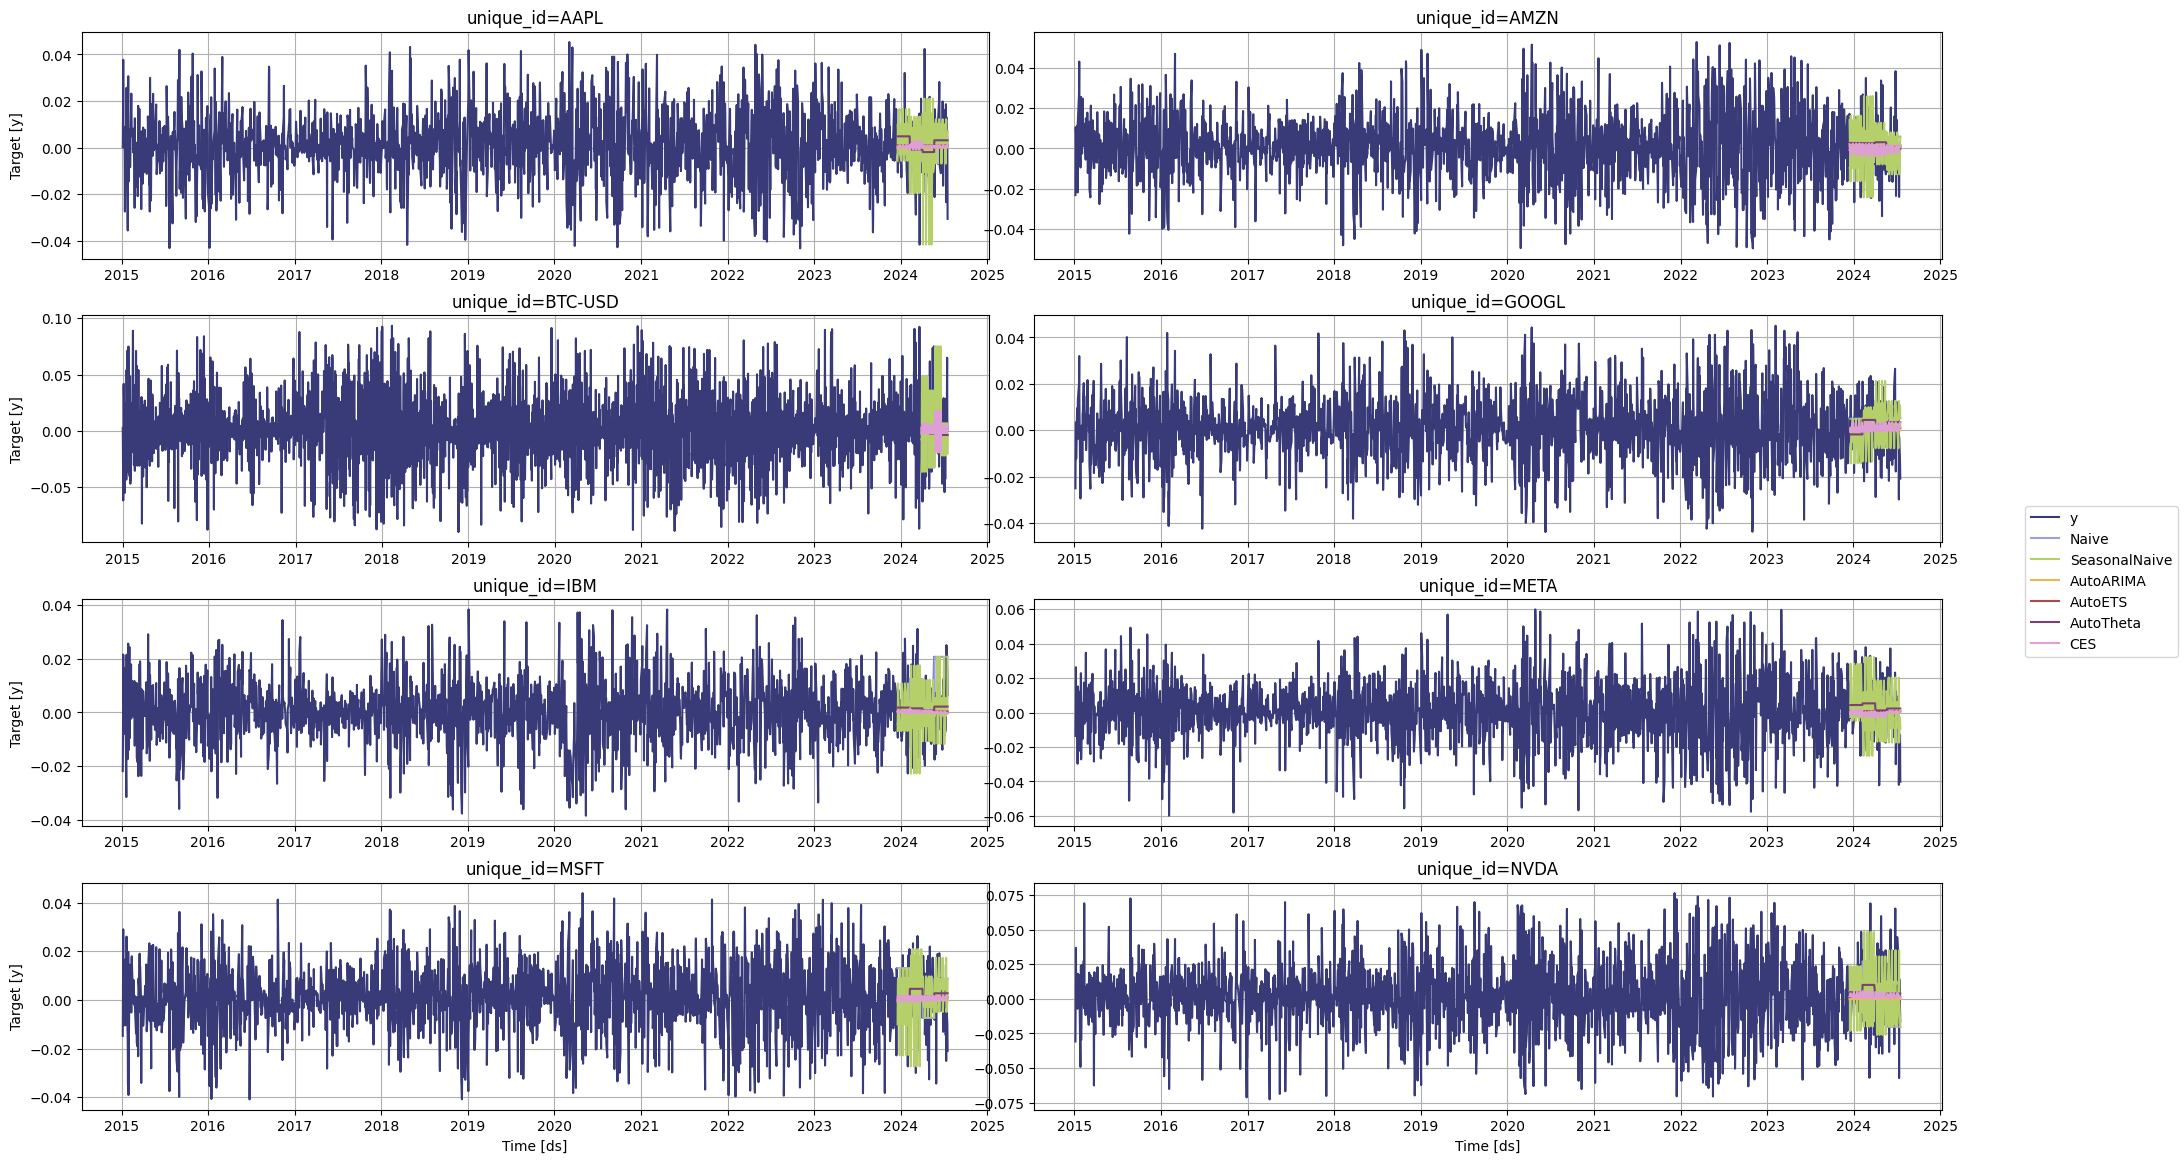

In [10]:
StatsForecast.plot(ts_not_anom, cv_df.drop(['cutoff', 'y'], axis=1))

In [11]:
cv_df = pd.DataFrame(cv_df)
cv_df.index.name = 'unique_id'

# Transformar índice en columna
cv_df.reset_index(inplace=True)

In [12]:
def evaluate(df: pd.DataFrame, metrics: List[Callable]) -> pd.DataFrame:
    eval_ = {}
    models = df.loc[:, ~df.columns.str.contains('unique_id|y|ds|cutoff|lo|hi')].columns
    for model in models:
        eval_[model] = {}
        for metric in metrics:
            eval_[model][metric.__name__] = metric(df['y'], df[model])
    eval_df = pd.DataFrame(eval_).rename_axis('metric').reset_index()
    eval_df.insert(0, 'cutoff', df['cutoff'].iloc[0])
    eval_df.insert(0, 'unique_id', df['unique_id'].iloc[0])
    return eval_df

In [13]:
str_models = cv_df.loc[:, ~cv_df.columns.str.contains('unique_id|y|ds|cutoff|lo|hi')].columns
str_models = ','.join([f"{model}:float" for model in str_models])
cv_df['cutoff'] = cv_df['cutoff'].astype(str)
cv_df['unique_id'] = cv_df['unique_id'].astype(str)

In [14]:
client = Client() # without this, dask is not in distributed mode
# fugue.dask.dataframe.default.partitions determines the default partitions for a new DaskDataFrame
engine = DaskExecutionEngine({"fugue.dask.dataframe.default.partitions": 96})


In [15]:
evaluation_df = transform(
    cv_df.loc[:, ~cv_df.columns.str.contains('lo|hi')], 
    evaluate, 
    engine="dask",
    params={'metrics': [mse, mae, mape, smape]}, 
    schema=f"unique_id:str,cutoff:str,metric:str, {str_models}", 
    as_local=True,
    partition={'by': ['unique_id', 'cutoff']}
)
evaluation_df.head()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask

2024-07-17 17:38:04,375 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 46339379258ba01be09b3403cf0cbd7f initialized by task ('shuffle-transfer-46339379258ba01be09b3403cf0cbd7f', 4) executed on worker tcp://127.0.0.1:52239
2024-07-17 17:38:08,549 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 46339379258ba01be09b3403cf0cbd7f deactivated due to stimulus 'task-finished-1721230688.532505'


,unique_id,cutoff,metric,Naive,SeasonalNaive,AutoARIMA,AutoETS,AutoTheta,CES
0,AAPL,2024-05-21,mse,0.000222,0.000212,0.000202,0.000199,0.000199,0.000198
1,AAPL,2024-05-21,mae,0.011369,0.011053,0.011711,0.011388,0.010892,0.011413
2,AAPL,2024-05-21,mape,112.796799,123.445511,100.189911,90.381683,83.892029,92.375359
3,AAPL,2024-05-21,smape,111.409737,128.136795,199.998154,163.026825,123.741913,173.316132
4,AMZN,2023-12-14,mse,0.000277,0.000273,0.000153,0.00015,0.00015,0.000144


In [16]:
# Calculate the mean metric for each cross validation window
evaluation_df.groupby(['cutoff', 'metric']).mean(numeric_only=True)

Naive  SeasonalNaive   AutoARIMA     AutoETS  \
cutoff     metric                                                       
2023-12-14 mae        0.014058       0.014787    0.012659    0.012404   
           mape     228.615082     280.521057   98.323013  101.190964   
           mse        0.000297       0.000362     0.00026    0.000249   
           smape    136.509003     112.795471  196.428574  172.468185   
2023-12-15 mae        0.009029       0.011666    0.008501    0.008383   
           mape      381.96814     485.947083    100.3004  114.517616   
           mse        0.000136       0.000234    0.000126    0.000122   
           smape    126.815063     140.169342  198.384293  169.901367   
2024-02-07 mae        0.020555       0.022441    0.015972    0.015937   
           mape     348.852478     322.050842   98.163231  105.121696   
           mse        0.000736       0.000798     0.00046    0.000454   
           smape    126.603897     135.319565  195.405334  178.388123   
2024-02-08 mae        0.011791       0.015059    0.011016    0.011083   
           mape     163.740936     420.100342  100.317688  114.002747   
           mse        0.000215       0.000361    0.000196    0.000195   
           smape    157.191788     142.791672  199.039658  182.203568   
2024-03-27 mae         0.02411        0.03216    0.023249    0.023253   
           mape      130.82634     337.108246   107.58284  105.080399   
           mse        0.000803       0.001528    0.000807    0.000798   
           smape    149.199417     147.410095  169.960205  179.437881   
2024-03-28 mae         0.01873        0.02324    0.018549    0.018565   
           mape     121.154587     191.247833  100.177979  104.085251   
           mse        0.000517       0.000865    0.000516    0.000512   
           smape    171.571503      151.65036  199.999908  180.660217   
2024-04-02 mae        0.012199        0.01348    0.010185    0.010021   
           mape      279.32843     313.702362  100.147713  103.027504   
           mse        0.000225       0.000273    0.000169    0.000167   
           smape    141.678619     146.803253  199.956711  170.896622   
2024-04-24 mae        0.037361       0.024123    0.022514    0.022593   
           mape    7922.236816    4336.689453  309.154022  437.655975   
           mse         0.00215       0.001073    0.000914    0.000912   
           smape    136.295563     130.495453  185.734863  180.591187   
2024-05-17 mae        0.022096        0.02128    0.016073    0.016051   
           mape     380.376343     424.935486  100.044334  121.966263   
           mse        0.000852       0.000828    0.000489    0.000479   
           smape    152.401978     151.999634  199.075073  175.296875   
2024-05-21 mae        0.013915       0.012459    0.010638    0.010532   
           mape     293.570679     229.045944   98.676964   97.724365   
           mse        0.000304       0.000265    0.000192    0.000193   
           smape    130.775787      137.05545  195.170059  165.027771   
2024-05-22 mae        0.015243       0.023631    0.011173     0.01126   
           mape     385.172272     497.719574  111.706749  119.264709   
           mse        0.000331       0.001085    0.000191    0.000195   
           smape    129.758087     138.849457  168.606964  161.975845   
2024-06-19 mae         0.01981       0.021676    0.019559    0.019554   
           mape     271.546875     327.268066  110.076942  175.693695   
           mse        0.000657       0.000745     0.00065    0.000651   
           smape    165.137375     141.212753  190.422928  174.372971   

                    AutoTheta         CES  
cutoff     metric                          
2023-12-14 mae       0.012082    0.012306  
           mape    126.320267  103.305176  
           mse       0.000235    0.000248  
           smape   141.809692  164.321793  
2023-12-15 mae       0.008868     0.00843  
           mape    186.941772  108.857666  
           mse       0

In [17]:
evaluation_df_melted = pd.melt(evaluation_df, id_vars=['unique_id', 'cutoff', 'metric'], var_name='model', value_name='error')

<Axes: xlabel='error', ylabel='model'>

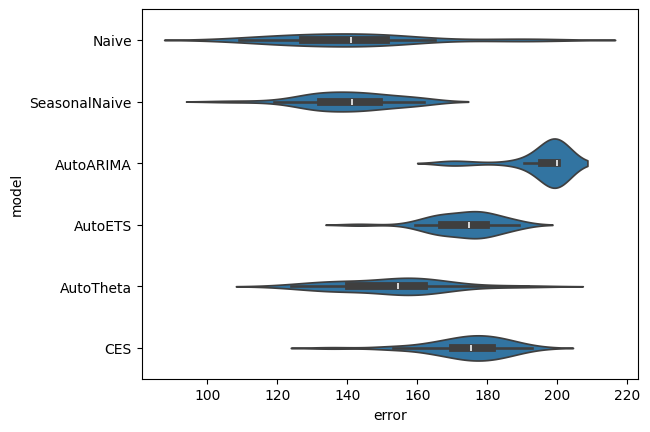

In [18]:
sns.violinplot(evaluation_df_melted.query('metric=="smape"'), x='error', y='model')

<Axes: xlabel='n', ylabel='best_model'>

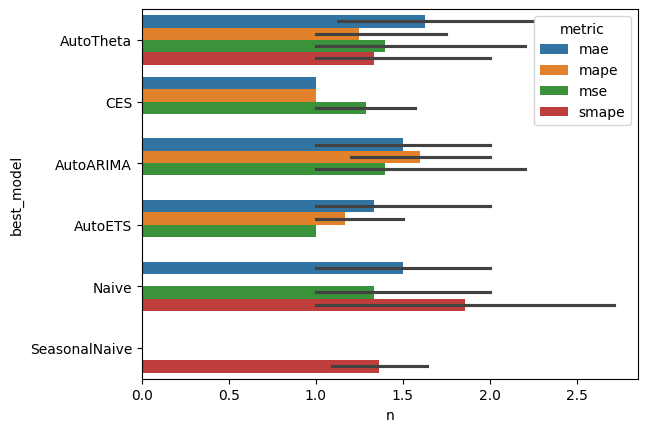

In [19]:
# Choose the best model for each time series, metric, and cross validation window
evaluation_df['best_model'] = evaluation_df.idxmin(axis=1, numeric_only=True)
# count how many times a model wins per metric and cross validation window
count_best_model = evaluation_df.groupby(['cutoff', 'metric', 'best_model']).size().rename('n').to_frame().reset_index()
# plot results
sns.barplot(count_best_model, x='n', y='best_model', hue='metric')